In [1]:
'''
Tring to emplement learning diverse skills maximum entropy deep RL(bair.berkeley.edu)
'''
# Taking epsilon = 0 
# After 500 time steps the game automaticly terminates

import math
import time
import random
import heapq as hp
import gym
import numpy as np
from keras import backend as K
import keras
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import tensorflow as tf

config =tf.ConfigProto(
        device_count={'GPU':0}
)
sess=tf.Session(config=config)

K.set_session(sess)


EPISODES = 1000

import math

def sigmoid(x):
    return 1 / (1 + math.exp(-x))


class DQNAgent:
    def __init__(self, state_size, action_size,epsilon_decay=0,gamma=0.95):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = {}
        self.pqt=[]
        self.gamma = gamma   # discount rate 0.95
        self.epsilon = 0.0  # exploration rate
        self.epsilon_min = 0.01   # epsilon_min = 0.01
        self.epsilon_decay = epsilon_decay  #0.99
        self.learning_rate = 0.001  # the learning rate:0.001
        self.model = self._build_model()
        self.pev_model=self._build_model()
        self.pev_model.set_weights(self.model.get_weights())
        
    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate))
        return model

    def remember(self, eps, state, action, reward, next_state, done):
        cort_rwd=(reward + self.gamma *
                          max(self.pev_model.predict(next_state)[0]))
        prd_rwd=self.model.predict(state)[0][action]        # state shouls be threr not next state
        hp.heappush(self.pqt,-abs(float(cort_rwd - prd_rwd)))
        self.memory[-abs(float(cort_rwd - prd_rwd))]=(state, action, reward, next_state, done)
        
        
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)[0]
        exact_values = [math.exp(x) for x  in act_values]
        sum_ext_values = sum(exact_values)
        std_exact_values = [sum(exact_values[:i+1])/sum_ext_values for i in range(len(act_values))]
        
        rd=np.random.rand()
        i=0
        while rd>std_exact_values[i]:
            i+=1
        
        
       
            
        return i  # returns action
    
    def replay(self, batch_size):
        
        for _ in range(batch_size):
            
            state, action, reward, next_state, done = self.memory[hp.heappop(self.pqt)]
            target = reward
            if not done:
                target = (reward + self.gamma *
                          np.amax(self.pev_model.predict(next_state)[0]))  # q(s,a) = r + max(q(_s,_a)) over _a
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)


if __name__ == "__main__":
    env = gym.make('CartPole-v1')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    time_start=time.time()
    
    agent = DQNAgent(state_size, action_size)
    # agent.load("./save/cartpole-dqn.h5")
    done = False
    batch_size = 64
    vally=0
    rslt=[]
    ep=[]
    
    for e in range(EPISODES):
        
        done=False
        state = env.reset()  # It's obdervation 'o'
        state = np.reshape(state, [1, state_size]) # Encapsulating whole thing into and array i.e [[1,12,2,3]]
        for t in range(500):      # The 1st comment, actually 'for' loop will work too
            
            env.render()
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            reward = reward if t==499 or not done else -100
            next_state = np.reshape(next_state, [1, state_size])
            agent.remember(e, state, action, reward, next_state, done)
            state = next_state
              
            if done and not t==499:
                agent.pev_model.set_weights(agent.model.get_weights())
                print("episode: {}/{}, score: {}, e: {:.2}"
                      .format(e, EPISODES, t, agent.epsilon))
                break
        rslt.append(t)
        if t>=499 : 
            vally+=1
            ep.append(e)
            print("Time for which pole stand:",t,vally)
            if len(ep)>2:
                
                if list(range(3))==[smt-ep[-3] for smt in ep[-3:]]:
                    print("Done after episode:",e-1)
                    break
                 
        if len(agent.pqt) > batch_size:
            agent.replay(batch_size)
    end_time=time.time()
    print(end_time-time_start)
        # if e % 10 == 0:
#     agent.save("./save/cartpole-dqn.h5")

Using TensorFlow backend.


episode: 0/1000, score: 13, e: 0.0
episode: 1/1000, score: 17, e: 0.0
episode: 2/1000, score: 8, e: 0.0
episode: 3/1000, score: 22, e: 0.0
episode: 4/1000, score: 24, e: 0.0
episode: 5/1000, score: 11, e: 0.0
episode: 6/1000, score: 12, e: 0.0
episode: 7/1000, score: 29, e: 0.0
episode: 8/1000, score: 10, e: 0.0
episode: 9/1000, score: 13, e: 0.0
episode: 10/1000, score: 51, e: 0.0
episode: 11/1000, score: 22, e: 0.0
episode: 12/1000, score: 10, e: 0.0
episode: 13/1000, score: 13, e: 0.0
episode: 14/1000, score: 29, e: 0.0
episode: 15/1000, score: 14, e: 0.0
episode: 16/1000, score: 20, e: 0.0
episode: 17/1000, score: 37, e: 0.0
episode: 18/1000, score: 24, e: 0.0
episode: 19/1000, score: 15, e: 0.0
episode: 20/1000, score: 23, e: 0.0
episode: 21/1000, score: 47, e: 0.0
episode: 22/1000, score: 18, e: 0.0
episode: 23/1000, score: 18, e: 0.0
episode: 24/1000, score: 14, e: 0.0
episode: 25/1000, score: 8, e: 0.0
episode: 26/1000, score: 19, e: 0.0
episode: 27/1000, score: 42, e: 0.0
epis

episode: 224/1000, score: 92, e: 0.0
episode: 225/1000, score: 176, e: 0.0
episode: 226/1000, score: 127, e: 0.0
episode: 227/1000, score: 260, e: 0.0
episode: 228/1000, score: 117, e: 0.0
episode: 229/1000, score: 32, e: 0.0
episode: 230/1000, score: 15, e: 0.0
episode: 231/1000, score: 30, e: 0.0
episode: 232/1000, score: 14, e: 0.0
episode: 233/1000, score: 18, e: 0.0
episode: 234/1000, score: 41, e: 0.0
episode: 235/1000, score: 43, e: 0.0
episode: 236/1000, score: 28, e: 0.0
episode: 237/1000, score: 95, e: 0.0
episode: 238/1000, score: 253, e: 0.0
episode: 239/1000, score: 190, e: 0.0
episode: 240/1000, score: 25, e: 0.0
episode: 241/1000, score: 18, e: 0.0
episode: 242/1000, score: 9, e: 0.0
episode: 243/1000, score: 11, e: 0.0
episode: 244/1000, score: 24, e: 0.0
episode: 245/1000, score: 14, e: 0.0
episode: 246/1000, score: 22, e: 0.0
episode: 247/1000, score: 39, e: 0.0
episode: 248/1000, score: 203, e: 0.0
episode: 249/1000, score: 146, e: 0.0
episode: 250/1000, score: 352, 

In [2]:
def policy_evaluation(env,agent1):
    avg=0
    for i in range(100):
        env.seed(85*i)
        state=env.reset()
        state=np.reshape(state,[1,agent1.state_size])
        action=np.argmax(agent1.model.predict(state)[0])
        nxt_state, reward, done, info = env.step(action)
        net_r=1
        while not done:
            env.render
            net_r+=reward
            state=nxt_state
            state=np.reshape(state, [1,agent1.state_size])
            action=np.argmax(agent1.model.predict(state)[0])
            nxt_state, reward, done, info = env.step(action)
            #print(nxt_state, reward, done)
        avg+=net_r
        rslt.append(net_r)
        print("Reward for {} episode: {}".format(i,net_r))
    print("Avg reward: ",avg/(i+1) )
    env.close()

In [3]:
policy_evaluation(env,agent)

Reward for 0 episode: 500.0
Reward for 1 episode: 500.0
Reward for 2 episode: 500.0
Reward for 3 episode: 500.0
Reward for 4 episode: 500.0
Reward for 5 episode: 500.0
Reward for 6 episode: 500.0
Reward for 7 episode: 500.0
Reward for 8 episode: 500.0
Reward for 9 episode: 500.0
Reward for 10 episode: 500.0
Reward for 11 episode: 500.0
Reward for 12 episode: 500.0
Reward for 13 episode: 500.0
Reward for 14 episode: 500.0
Reward for 15 episode: 500.0
Reward for 16 episode: 500.0
Reward for 17 episode: 500.0
Reward for 18 episode: 500.0
Reward for 19 episode: 500.0
Reward for 20 episode: 500.0
Reward for 21 episode: 500.0
Reward for 22 episode: 500.0
Reward for 23 episode: 500.0
Reward for 24 episode: 500.0
Reward for 25 episode: 500.0
Reward for 26 episode: 500.0
Reward for 27 episode: 500.0
Reward for 28 episode: 500.0
Reward for 29 episode: 500.0
Reward for 30 episode: 500.0
Reward for 31 episode: 500.0
Reward for 32 episode: 500.0
Reward for 33 episode: 500.0
Reward for 34 episode: 5

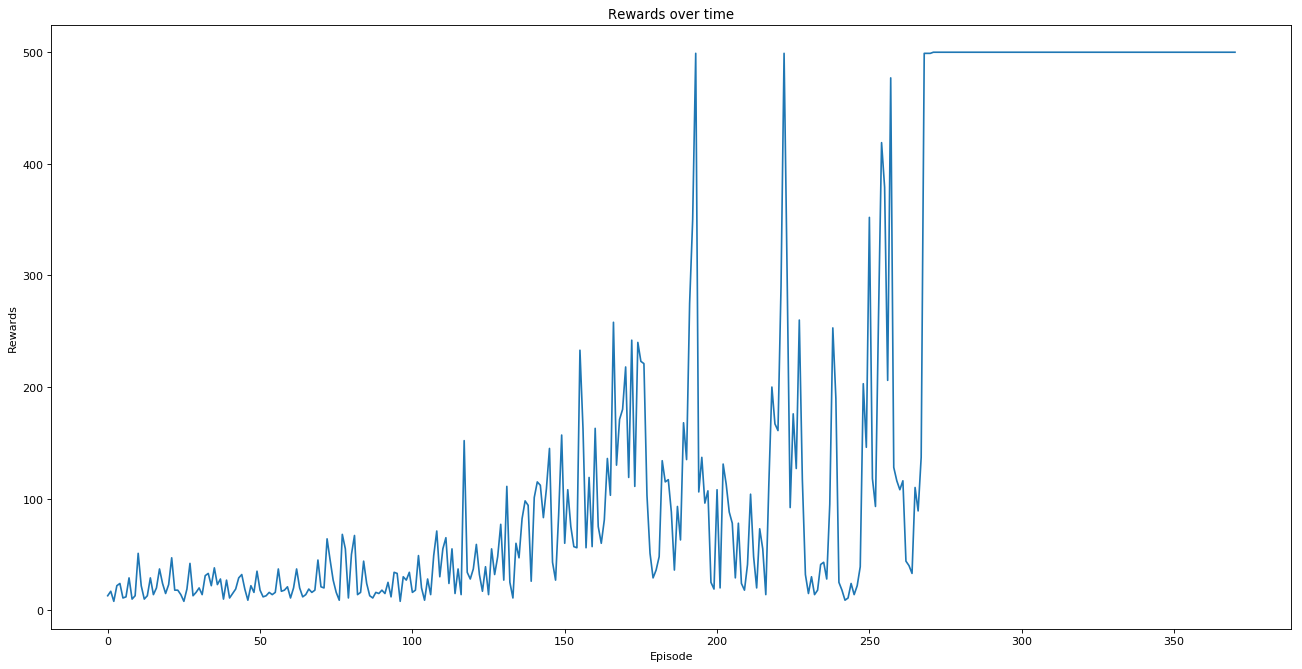

In [5]:
import matplotlib.pyplot as plt

plt.figure(num=None, figsize=(20,10), dpi=80, facecolor='w', edgecolor='k')
plt.plot(rslt)
plt.xlabel('Episode')
plt.ylabel('Rewards')
plt.title('Rewards over time')
#plt.savefig("./cartpole_ddqn.png")
plt.show()